In [46]:
import numpy as np
import matplotlib.pyplot as plt
import ompy as om
import logging
import pandas as pd

import scipy as sp
#%matplotlib widget
from ipywidgets import widgets #interact, interactive, fixed, interact_manual

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

In [47]:
om.__full_version__;

# For reproducability we seed the random generator.
# Note that by default several other classes in ompy, such as all
# classes with multinest calculations have a default seed, too
np.random.seed(1382398)

In [48]:
plt.rcParams["figure.dpi"] = 80
plt.rcParams["errorbar.capsize"] = 5
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams['font.size'] = 25
plt.rcParams['xtick.major.size'] = 12
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams['ytick.major.size'] = 12
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.width'] = 2
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['lines.linewidth'] = 3.0
plt.rcParams['axes.linewidth'] = 1.5

Import $\gamma$SF and NLD from Oslo Method

In [49]:
gsf_file = pd.read_csv('strength.nrm')
gsf_file = gsf_file[(gsf_file.T != 0).any()]
gsf_om, gsf_om_error = np.split(np.asarray(gsf_file), 2)

nld_file = pd.read_csv('rhopaw.cnt')
nld_file = nld_file[(nld_file.T != 0).any()]
nld_om, nld_om_error = np.split(np.asarray(nld_file), 2)

#very ugly workaround
gsf_om_error_new = np.zeros(len(gsf_om_error))
nld_om_error_new = np.zeros(len(nld_om_error))
for i in range(len(gsf_om)):
    gsf_om_error_new[i] = gsf_om_error[i][0]
for i in range(len(nld_om)):
    nld_om_error_new[i] = nld_om_error[i][0]
gsf_om_error = gsf_om_error_new
nld_om_error = nld_om_error_new
    
#from oslo method normalization
a0 = -0.8671
a1 = 0.1037
energy_gsf_om = np.linspace(999.9, 5252, len(gsf_om))
energy_nld_om = np.linspace(0, 5252-999.9, len(nld_om))
for i in range(len(gsf_om)):
    energy_gsf_om[i] = ((a0 + a1*energy_gsf_om[i])*1e1)*1e-3
for i in range(len(nld_om)):
    energy_nld_om[i] = ((a0 + a1*energy_nld_om[i])*1e1)*1e-3  


3.8701633e-09

Import $\gamma$SF and NLD from OmPy

In [50]:
def getMedianQuantile(func):
    func = pd.DataFrame(func)
    func_median = pd.DataFrame.median(func)
    func_error_low = func.quantile(0.16)
    func_error_high = func.quantile(0.84)
    func_error = func_error_high - func_error_low
    return func_median, func_error

def read_ompy(path):
    """
    path must not include / at the end
    """
    energy_gsf = pd.read_csv(path+'/gsf_0.txt', sep=" ", header=None, skiprows=[0])[0]*1e-3
    energy_nld = pd.read_csv(path+'/nld_0.txt', sep=" ", header=None, skiprows=[0])[0]*1e-3
    gsf = np.zeros((99, len(energy_gsf)))
    nld = np.zeros((99, len(energy_nld)))
    
    for i in range(99):
        #print(i)
        if i!=76:
            gsf[i] = pd.read_csv(path+'/gsf_%.0i.txt'%i, sep=" ", header=None, skiprows=[0])[1]
            nld[i] = pd.read_csv(path+'/nld_%.0i.txt'%i, sep=" ", header=None, skiprows=[0])[1]
    
    gsf_median, gsf_error = getMedianQuantile(gsf)
    nld_median, nld_error = getMedianQuantile(nld)
    
    return energy_gsf, gsf_median, gsf_error, energy_nld, nld_median, nld_error

#path = '/home/tellefs/Documents/master/OmPy_233U/normalized_data/ensemble_simnorm_nld_gsf_250_kevperbin' #Ubuntu on laptop
path = '/Users/tellefs/Documents/master/OmPy_233U/normalized_data/ensemble_simnorm_nld_gsf_250_kevperbin' #iMac at office

energy_gsf_ompy, gsf_ompy_median, gsf_ompy_error, energy_nld_ompy, nld_ompy_median, nld_ompy_error = read_ompy(path)

0     1.549633e-08
1     1.555548e-08
2     1.565286e-08
3     2.086075e-08
4     2.988269e-08
5     2.976057e-08
6     3.026639e-08
7     2.092121e-08
8     1.708765e-08
9     1.133903e-08
10    3.018569e-08
11    5.062737e-08
12    9.412775e-08
13    1.583055e-07
14    1.875895e-07
15    1.616391e-07
16    4.663254e-07
dtype: float64

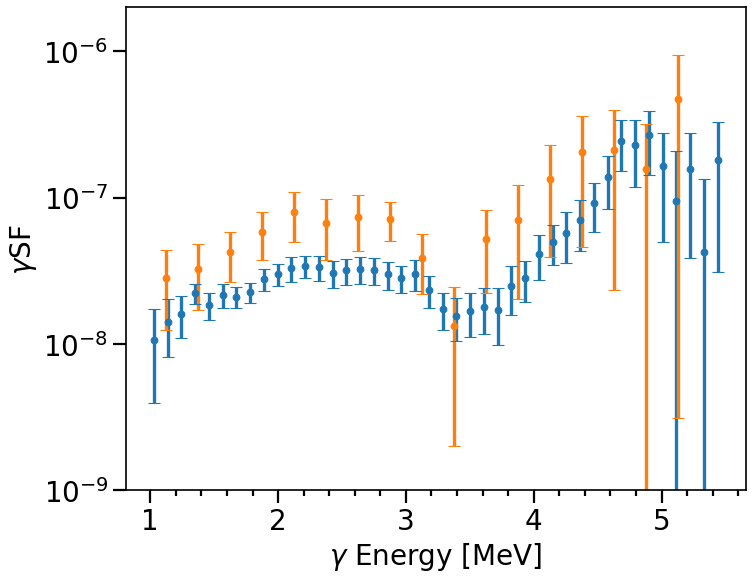

In [51]:

fig, ax = plt.subplots()
ax.errorbar(x=energy_gsf_om, y=gsf_om, yerr=gsf_om_error, marker='o', linestyle='')
ax.errorbar(x=energy_gsf_ompy, y=gsf_ompy_median, yerr=gsf_ompy_error, marker='o', linestyle='')
ax.set_ylim(1e-9, 2e-6)
ax.set_yscale('log')
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.set_xlabel('$\gamma$ Energy [MeV]')
ax.set_ylabel('$\gamma$SF')

fig.show()

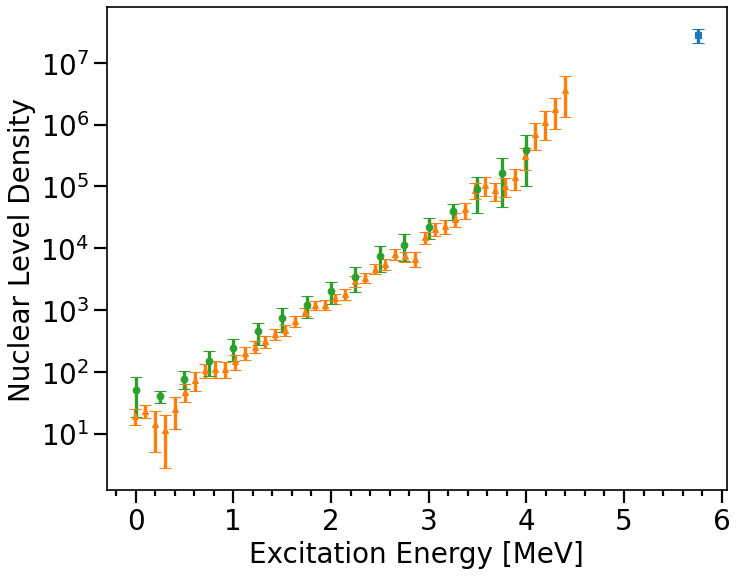

In [54]:


Sn = 5.762
rhoSn = 28.07e6
rhoSn_error = 7.02e6

#import discrete levels and make histogram
#discrete_levels = pd.read_csv('/home/tellefs/Documents/master/OmPy_233U/discrete_levels_U233.txt', header=None, skiprows=[0,1])
#discrete_levels *= 1e-3
#discrete_levels= np.histogram(discrete_levels, bins=25)


fig, ax = plt.subplots()
ax.errorbar(x=Sn, y=rhoSn, yerr=rhoSn_error, marker='s', linestyle='')
#ax.step(discrete_levels[1][:-1], discrete_levels[0])
ax.errorbar(x=energy_nld_om, y=nld_om, yerr=nld_om_error, marker='^', linestyle='')
ax.errorbar(x=energy_nld_ompy, y=nld_ompy_median, yerr=nld_ompy_error, marker='o', linestyle='')
ax.set_yscale('log')

ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.set_xlabel('Excitation Energy [MeV]')
ax.set_ylabel('Nuclear Level Density')

fig.show()
